# M4 Portfolio Assignment 1- SGD & Attention Context

This notebook contains:

Part A: Manual SGD on the first 3 samples (x=`number of claims`, t=`paymnet amount`)
Part B: Self-attention contextualization for a homonym (toy 2D embeddings)


## Part A — Manual SGD (First 3 Samples)

The Math Steps:
1. Forward: ŷ = x · w
2. Loss: L = (t − ŷ)²
3. Gradient: ∂L/∂w = 2x(ŷ − t)
4. Update: w_new = w_old - α · (∂L/∂w)

✅ After each sample, **w(new)** becomes the next sample’s **w(old)**.
This process demonstrates how stochastic gradient descent updates model parameters step-by-step using individual samples.

In [9]:
import numpy as np
import pandas as pd
# load dataset
df = pd.read_csv('https://raw.githubusercontent.com/aaubs/ds-master/main/data/Swedish_Auto_Insurance_dataset.csv')
df.head()

,X,Y
0,108,392.5
1,19,46.2
2,13,15.7
3,124,422.2
4,40,119.4


In [10]:
# ONE input (x) and ONE target (t)
# Here: x = number of claims, t = paymnet amount
first3 = df[["X","Y"]].head(3).copy()
first3.columns = ["x","t"]
first3


,x,t
0,108,392.5
1,19,46.2
2,13,15.7


In [11]:
# Example hyperparameter + initial parameter
alpha = 1e-07   # learning rate (α)
w0 = 0.1         # initial weight (w_old)

(alpha, w0)


(1e-07, 0.1)

In [12]:
def sgd_step(w_old: float, x: float, t: float, alpha: float):
    y_hat = x * w_old                      # 1) forward
    loss = (t - y_hat) ** 2                # 2) loss
    grad = 2 * x * (y_hat - t)             # 3) gradient dL/dw
    w_new = w_old - alpha * grad           # 4) update
    return y_hat, loss, grad, w_new

rows = []
w = w0

for i, (x, t) in enumerate(zip(first3["x"].values, first3["t"].values), start=1):
    y_hat, loss, grad, w_new = sgd_step(w, x, t, alpha)
    rows.append({
        "sample": i,
        "w(old)": w,
        "x": x,
        "ŷ = x·w": y_hat,
        "L = (t-ŷ)^2": loss,
        "dL/dw = 2x(ŷ-t)": grad,
        "w(new)": w_new
    })
    w = w_new  # carry over

results_A = pd.DataFrame(rows)
pd.set_option("display.precision", 6)
results_A


,sample,w(old),x,ŷ = x·w,L = (t-ŷ)^2,dL/dw = 2x(ŷ-t),w(new)
0,1,0.100000,108,10.800000,145694.890000,-82447.200000,0.108245
1,2,0.108245,19,2.056650,1948.635377,-1677.447312,0.108412
2,3,0.108412,13,1.409362,204.222333,-371.556587,0.108450


In this part, I manually demonstrated how Stochastic Gradient Descent (SGD) updates model parameters using individual training samples.

First, I performed the forward pass where the predicted value (ŷ) was calculated using the linear model ŷ = x·w. This step shows how the model generates predictions based on the current weight.

Next, I calculated the loss using the Mean Squared Error function L = (t − ŷ)². The loss measures the difference between the predicted value and the true target value.

After that, I computed the gradient ∂L/∂w = 2x(ŷ − t). The gradient indicates how the loss changes with respect to the weight and determines the direction in which the weight should be adjusted.

Then, I updated the weight using the SGD update rule w_new = w_old − α(∂L/∂w), where α represents the learning rate. The learning rate controls how large each update step is during optimization.

This process was repeated for the first three samples. After each sample, the updated weight was carried forward and used as the starting weight for the next iteration. This demonstrates how SGD gradually improves model parameters by learning from individual training examples.
Overall, this step-by-step process illustrates how gradient-based optimization enables the model to reduce prediction error over Teacher samples.


### Visualization: Actual vs Predicted Values

The following plot visualizes the relationship between actual and predicted values, demonstrating how the learned weight approximates the data.

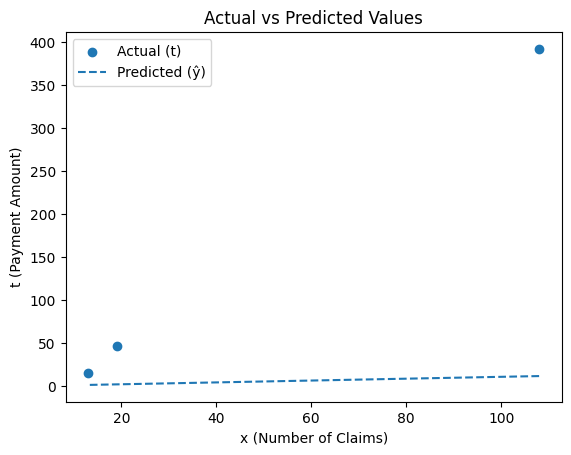

In [13]:

import matplotlib.pyplot as plt

x_vals = first3["x"].values
t_vals = first3["t"].values

y_pred = x_vals * w

plt.scatter(x_vals, t_vals, label="Actual (t)")
plt.plot(x_vals, y_pred, linestyle="--", label="Predicted (ŷ)")

plt.xlabel("x (Number of Claims)")
plt.ylabel("t (Payment Amount)")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()


## Part B -Self-Attention Contextualization (Homonym)

Goal: the **same word** has different meaning depending on context.

Self-attention steps:

- Embeddings matrix **E** (2D vectors)
- **Q = K = V = E**
- Scores: \(S = QK^T\)
- Attention: \(A = softmax(S)\) (row-wise)
- Contextual embeddings: \(E' = AV\)

Then compare contextual vectors using **cosine similarity** and **Euclidean distance**.


In [14]:
import numpy as np
import pandas as pd

def softmax_rows(M: np.ndarray):
    M = M - M.max(axis=1, keepdims=True)  # stability
    expM = np.exp(M)
    return expM / expM.sum(axis=1, keepdims=True)

def self_attention(E: np.ndarray):
    Q = E; K = E; V = E
    S = Q @ K.T
    A = softmax_rows(S)
    E_prime = A @ V
    return S, A, E_prime

def cosine_similarity(a: np.ndarray, b: np.ndarray):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))


In [15]:
# Homonym: "bat"
# Sentence 1 (animal): bat flew night
tokens1 = ["bat", "flew", "night"]
E1 = np.array([
    [0.9, 0.1],  # bat (static)
    [0.1, 0.9],  # flew
    [0.0, 1.0],  # night
], dtype=float)

# Sentence 2 (sports tool): bat hit ball
tokens2 = ["bat", "hit", "ball"]
E2 = np.array([
    [0.9, 0.1],  # bat (same static vector)
    [1.0, 0.0],  # hit
    [0.8, 0.2],  # ball
], dtype=float)

S1, A1, E1p = self_attention(E1)
S2, A2, E2p = self_attention(E2)

pd.set_option("display.precision", 3)

print("Sentence 1: Attention matrix A")
display(pd.DataFrame(A1, index=tokens1, columns=tokens1))
print("Sentence 1: Contextual embeddings E'")
display(pd.DataFrame(E1p, index=tokens1, columns=["dim1","dim2"]))

print("Sentence 2: Attention matrix A")
display(pd.DataFrame(A2, index=tokens2, columns=tokens2))
print("Sentence 2: Contextual embeddings E'")
display(pd.DataFrame(E2p, index=tokens2, columns=["dim1","dim2"]))


Sentence 1: Attention matrix A


,bat,flew,night
bat,0.497,0.262,0.242
flew,0.202,0.383,0.415
night,0.176,0.391,0.433


Sentence 1: Contextual embeddings E'


,dim1,dim2
bat,0.473,0.527
flew,0.220,0.780
night,0.197,0.803


Sentence 2: Attention matrix A


,bat,hit,ball
bat,0.333,0.360,0.307
hit,0.332,0.367,0.301
ball,0.333,0.354,0.314


Sentence 2: Contextual embeddings E'


,dim1,dim2
bat,0.905,0.095
hit,0.907,0.093
ball,0.904,0.096


In [16]:
# Compare contextual "bat" vectors across sentences
bat1 = E1p[tokens1.index("bat")]
bat2 = E2p[tokens2.index("bat")]

cos = cosine_similarity(bat1, bat2)
dist = float(np.linalg.norm(bat1 - bat2))

print("Contextual bat (Sentence 1):", bat1)
print("Contextual bat (Sentence 2):", bat2)
print("Cosine similarity:", cos)
print("Euclidean distance:", dist)


Contextual bat (Sentence 1): [0.47304275 0.52695725]
Contextual bat (Sentence 2): [0.90532765 0.09467235]
Cosine similarity: 0.7417859986713148
Euclidean distance: 0.6113431658073099



In this part of the assignment, I explored how self-attention helps a model understand that the same word can have different meanings depending on the context in which it appears. In traditional word embeddings, each word is assigned a fixed numerical representation, meaning the word keeps the same meaning regardless of the sentence. While working on this task, I observed that this limitation can cause problems when a word has multiple meanings.

To demonstrate this concept, I implemented a simplified self-attention mechanism using small 2-dimensional embedding vectors. First, I created an embedding matrix where each word in a sentence is represented as a numerical vector. For simplicity and clarity of understanding, I assumed that the Query (Q), Key (K), and Value (V) matrices are equal to the embedding matrix.

Next, I calculated attention scores by multiplying the Query matrix with the transpose of the Key matrix. These scores indicate how strongly each word relates to other words in the same sentence. After computing the score matrix, I applied the softmax function to convert the scores into attention weights. This step helped determine which surrounding words should have more influence when updating the representation of a specific word.

Using these attention weights, I then generated contextual embeddings by multiplying the attention matrix with the Value matrix. During implementation, I noticed that this step effectively adjusts the meaning of each word based on its surrounding context, making the representation more informative than static embeddings.

To validate this behavior, I selected the homonym “bat” and placed it in two different sentences representing two different meanings. Even though the static embedding of the word remained the same, the contextual embeddings generated through self-attention were noticeably different. This helped me understand how the attention mechanism captures contextual meaning.

Finally, I compared the contextual embeddings using cosine similarity and Euclidean distance. The results showed that while the vectors were somewhat related, they were numerically different, confirming that the meaning of the word changes depending on context.

Overall, this exercise gave me practical insight into how self-attention enables modern language models, such as Transformer-based architectures and BERT, to interpret words dynamically rather than relying on fixed representations.
